## 1. Installing Libraries

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp

## 2. Keypoints using MP Holistic

In [2]:
mp_holistic= mp.solutions.holistic #holistic model
mp_drawing= mp.solutions.drawing_utils 

In [3]:
def mediapipe_detection(image, model):
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #colour conversion
    image.flags.writeable= False  #Image no longer writeable
    results= model.process(image)
    image.flags.writeable=True
    image= cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results
    

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    

In [5]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), #dot colour
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))#line colour
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))
    
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))
    
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))
    
    

In [6]:
cap= cv2.VideoCapture(0)

#setting media pipeline model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame= cap.read()
        
        #Make detections
        image, results= mediapipe_detection(frame, holistic)
        
        #Drawing landmarks
        draw_styled_landmarks(image, results)
        
        cv2.imshow('OpenCV Feed', image)
        
        if cv2.waitKey(10) & 0xFF ==ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

## 3. Extracting Keypoint Values

In [7]:
results.pose_landmarks.landmark[0]

x: 0.6004014015197754
y: 0.49734383821487427
z: -1.558250069618225
visibility: 0.9985643625259399

In [8]:
pose= np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]) if results.pose_landmarks else np.zeros(33*4)
lh= np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)

In [9]:
lh

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
len(lh)

63

It's possible that there's no left or right hand in the frame at a given time and if we calculate the landmarks it will throw error. The best case to handle it is to replace it with a zeros array of the same shape.

In [11]:
rh= np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else np.zeros(21*3)

In [12]:
rh

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
len(results.face_landmarks.landmark)

468

In [14]:
face= np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)

In [15]:
face

array([ 0.59513426,  0.5255459 , -0.03860747, ...,  0.67084616,
        0.39834365,  0.03122935])

In [16]:
#wrapping everything in a function

def extract_keypoints(results):
    pose= np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face= np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh= np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh= np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])
    

In [17]:
result_test= extract_keypoints(results)

## 4. Setting up Folders for Collection

In [18]:
DATA_PATH= os.path.join('MP_data') #path for exported data
actions= np.array(['hello', 'thanks', 'iloveyou'])


no_sequences = 30   #30 videos worth of data
sequence_length= 30  #using 30 frames to classify the action

The key difference between action detection and computer vision is that a sequence of data rather than a single frame is used in it. 

In [19]:
#hello
##0
##1
#...
##29

#thanks

#iloveyou

In [20]:
#Making folders

for action in actions:
    for sequence in range(no_sequences):
        os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))

## 5. Collecting Keypoint Values for Training and Testing

In [21]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)


                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(1000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [22]:
cap.release()
cv2.destroyAllWindows()

## 6. Preprocessing Data and creating Labels and Features

In [23]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [24]:
label_map= {label: num for num , label in enumerate(actions)}
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [25]:
sequences, labels= [], [] #these are going to represent the X and y data respectively
for action in actions:
    for sequence in range(no_sequences):
        window=[]
        for frame_num in range(sequence_length):
            res= np.load(os.path.join(DATA_PATH, action, str(sequence), '{}.npy'.format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action]) 

In [26]:
np.array(sequences).shape

(90, 30, 1662)

In [89]:
X= np.array(sequences)
y=to_categorical(labels).astype(int)

In [90]:
X_train, X_test, y_train, y_test= train_test_split(X, y , test_size=0.05, random_state=42)

In [91]:
y_test.shape

(5, 3)

In [92]:
X_train.shape

(85, 30, 1662)

## 7. Build and Train LSTM Neural Network

In [93]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard

In [94]:
log_dir= os.path.join('Logs')
tb_callback = TensorBoard(log_dir= log_dir)

In [95]:
model= Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [96]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [127]:
model.fit(X_train, y_train, epochs=150, callbacks=[tb_callback])

Epoch 1/150
3/3 [==============================] - 0s 109ms/step - loss: 0.0681 - categorical_accuracy: 0.9765
Epoch 2/150
3/3 [==============================] - 0s 97ms/step - loss: 0.0754 - categorical_accuracy: 0.9529
Epoch 3/150
3/3 [==============================] - 0s 103ms/step - loss: 0.0627 - categorical_accuracy: 0.9647
Epoch 4/150
3/3 [==============================] - 0s 100ms/step - loss: 0.0719 - categorical_accuracy: 1.0000
Epoch 5/150
3/3 [==============================] - 0s 104ms/step - loss: 0.0547 - categorical_accuracy: 0.9765
Epoch 6/150
3/3 [==============================] - 0s 99ms/step - loss: 0.0598 - categorical_accuracy: 0.9647
Epoch 7/150
3/3 [==============================] - 0s 102ms/step - loss: 0.0546 - categorical_accuracy: 1.0000
Epoch 8/150
3/3 [==============================] - 0s 100ms/step - loss: 0.0584 - categorical_accuracy: 0.9765
Epoch 9/150
3/3 [==============================] - 0s 103ms/step - loss: 0.0489 - categorical_accuracy: 0.9882
Epo

3/3 [==============================] - 0s 134ms/step - loss: 0.0154 - categorical_accuracy: 1.0000
Epoch 75/150
3/3 [==============================] - 0s 100ms/step - loss: 0.0133 - categorical_accuracy: 1.0000
Epoch 76/150
3/3 [==============================] - 0s 97ms/step - loss: 0.0154 - categorical_accuracy: 1.0000
Epoch 77/150
3/3 [==============================] - 0s 109ms/step - loss: 0.0140 - categorical_accuracy: 1.0000
Epoch 78/150
3/3 [==============================] - 0s 179ms/step - loss: 0.0202 - categorical_accuracy: 1.0000
Epoch 79/150
3/3 [==============================] - 0s 99ms/step - loss: 0.0180 - categorical_accuracy: 0.9882
Epoch 80/150
3/3 [==============================] - 0s 99ms/step - loss: 0.0163 - categorical_accuracy: 1.0000
Epoch 81/150
3/3 [==============================] - 0s 149ms/step - loss: 0.0128 - categorical_accuracy: 1.0000
Epoch 82/150
3/3 [==============================] - 0s 98ms/step - loss: 0.0203 - categorical_accuracy: 0.9882
Epoch 83/

Epoch 147/150
3/3 [==============================] - 0s 119ms/step - loss: 0.0153 - categorical_accuracy: 0.9882
Epoch 148/150
3/3 [==============================] - 0s 130ms/step - loss: 0.0101 - categorical_accuracy: 1.0000
Epoch 149/150
3/3 [==============================] - 0s 112ms/step - loss: 0.0137 - categorical_accuracy: 1.0000
Epoch 150/150
3/3 [==============================] - 0s 133ms/step - loss: 0.0187 - categorical_accuracy: 0.9882


In [128]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_10 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_9 (Dense)             (None, 128)               8320      
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                                 
 dense_11 (Dense)            (None, 3)                 99        
                                                                 
Total params: 602,883
Trainable params: 602,883
Non-tr

## 8. Making Predictions

In [134]:
res= model.predict(X_test)

1/1 [==============================] - 0s 40ms/step


In [135]:
np.argmax(res[0]) #showing that position 1 is the action performed

1

In [136]:
actions[np.argmax(res[0])]

'thanks'

In [137]:
actions[np.argmax(y_test[0])] #performing pretty well

'thanks'

## 9. Save weights

In [138]:
model.save('action.h5')

## 10. Evaluation

In [139]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [140]:
yhat= model.predict(X_test)

1/1 [==============================] - 0s 39ms/step


In [141]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [145]:
ytrue

[1, 0, 1, 2, 0]

In [146]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[3, 0],
        [1, 1]],

       [[3, 0],
        [0, 2]],

       [[3, 1],
        [0, 1]]], dtype=int64)

In [147]:
accuracy_score(ytrue, yhat)

0.8

## 11. Test in real time

In [148]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

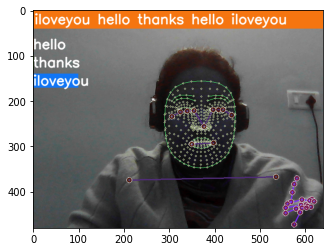

In [152]:

plt.imshow(prob_viz(res, actions, image, colors))

In [150]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
        
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

1/1 [==============================] - 0s 39ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 37ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 38ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
ilov

1/1 [==============================] - 0s 27ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 14ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 38ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
thanks
<class 'media

1/1 [==============================] - 0s 27ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 41ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 41ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
iloveyou
<class 'media

1/1 [==============================] - 0s 26ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 34ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 38ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
iloveyou
